In [0]:
'''
referenced from:
https://www.kaggle.com/creatrol/basic-time-series-analysis-feature-selection
https://www.kaggle.com/dedecu/cross-correlation-time-lag-with-pandas

'''


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout, Activation
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import keras.backend as K
from keras.layers import Layer
import seaborn as sns
import os
import datetime
import xgboost as xgb
from sklearn import model_selection, preprocessing

In [3]:
# !pip install finta
# !pip install alpha-vantage
!pip install sklearn-pandas

In [0]:
np.random.seed(7)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [6]:
# change stock here
df = pd.read_csv('/content/drive/My Drive/ZNH.csv')
df.head()

Date   open   high    low  close  volume  5 period SMA  10 period SMA  \
0  19/4/2013  26.52  26.52  26.27  26.39   20439        25.402         25.704   
1  22/4/2013  26.65  26.65  26.36  26.53    9098        25.856         25.769   
2  23/4/2013  26.40  26.62  26.26  26.46   18341        25.972         25.744   
3  24/4/2013  26.87  27.11  26.82  27.10    9778        26.366         25.843   
4  25/4/2013  27.40  27.40  26.94  27.17   17635        26.730         25.982   

   50 period SMA  100 period SMA  ...    20 period CCI      MACD    SIGNAL  \
0        27.3598       26.774949  ...        -1.797501 -0.565846 -0.530020   
1        27.3128       26.772500  ...        -0.249581 -0.476892 -0.519395   
2        27.2520       26.815600  ...        -0.205337 -0.407345 -0.496985   
3        27.2084       26.863100  ...         4.071922 -0.297180 -0.457024   
4        27.1612       26.913700  ...         5.393245 -0.201899 -0.405999   

   14 period ADX.     m_open     m_high      m_low    m_close  m_volume  Label  
0       65.626765  8994.1201  8994.1201  8994.1201  8994.1201         0      0  
1       66.882274     0.0000     0.0000     0.0000     0.0000         0      1  
2       67.774171  9113.7998  9113.7998  9113.7998  9113.7998         0      0  
3       69.417820  9146.4600  9146.4600  9146.4600  9146.4600         0      1  
4       67.664304     0.0000     0.0000     0.0000     0.0000         0      1  

[5 rows x 24 columns]

In [6]:
df.columns

Index(['Date', 'open', 'high', 'low', 'close', 'volume', '5 period SMA',
       '10 period SMA', '50 period SMA', '100 period SMA', 'RSI',
       '14 period STOCH %K', '14 Williams %R', 'On Volume Balance',
       '20 period CCI', 'MACD', 'SIGNAL', '14 period ADX.', 'm_open', 'm_high',
       'm_low', 'm_close', 'm_volume', 'Label'],
      dtype='object')

In [0]:
# standard scaling
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper
sdf =  df.drop(['Date','Label'], axis=1)
mapper = DataFrameMapper([(sdf.columns, StandardScaler())])
scaled_features = mapper.fit_transform(sdf.copy(), 4)
scaled_features_df = pd.DataFrame(scaled_features, index=sdf.index, columns=sdf.columns)

In [8]:
scaled_features_df.head()

open      high       low     close    volume  5 period SMA  \
0 -0.441226 -0.456777 -0.445428 -0.452004 -0.533740     -0.533549   
1 -0.430593 -0.446259 -0.437983 -0.440552 -0.783731     -0.496291   
2 -0.451041 -0.448686 -0.446256 -0.446278 -0.579987     -0.486772   
3 -0.412600 -0.409040 -0.399931 -0.393929 -0.768741     -0.454438   
4 -0.369251 -0.385576 -0.390004 -0.388203 -0.595549     -0.424567   

   10 period SMA  50 period SMA  100 period SMA       RSI    ...     \
0      -0.509446      -0.383119       -0.448967  0.227273    ...      
1      -0.504093      -0.387125       -0.449186  0.301836    ...      
2      -0.506152      -0.392308       -0.445329  0.251992    ...      
3      -0.497998      -0.396024       -0.441077  0.633622    ...      
4      -0.486551      -0.400047       -0.436549  0.674406    ...      

   On Volume Balance  20 period CCI      MACD    SIGNAL  14 period ADX.  \
0          -0.575959      -0.101358 -0.416340 -0.408170        3.097683   
1          -0.610997      -0.027147 -0.352778 -0.400175        3.213699   
2          -0.595401      -0.025026 -0.303084 -0.383312        3.296115   
3          -0.626842       0.180036 -0.224365 -0.353242        3.447998   
4          -0.643604       0.243384 -0.156283 -0.314847        3.285963   

     m_open    m_high     m_low   m_close  m_volume  
0  0.130302  0.130302  0.130302  0.130302       0.0  
1 -1.672364 -1.672364 -1.672364 -1.672364       0.0  
2  0.154289  0.154289  0.154289  0.154289       0.0  
3  0.160835  0.160835  0.160835  0.160835       0.0  
4 -1.672364 -1.672364 -1.672364 -1.672364       0.0  

[5 rows x 22 columns]

## time lag cross correlation

In [0]:
def df_derived_by_shift(df,lag=0,NON_DER=[]):
    df = df.copy()
    if not lag:
        return df
    cols ={}
    for i in range(1,lag+1):
        for x in list(df.columns):
            if x not in NON_DER:
                if not x in cols:
                    cols[x] = ['{}_{}'.format(x, i)]
                else:
                    cols[x].append('{}_{}'.format(x, i))
    for k,v in cols.items():
        columns = v
        dfn = pd.DataFrame(data=None, columns=columns, index=df.index)    
        i = 1
        for c in columns:
            dfn[c] = df[k].shift(periods=i)
            i+=1
        df = pd.concat([df, dfn], axis=1, join_axes=[df.index])
    return df

In [0]:
# changed time lag to 3 for display (originally used time lag = 5)
lag = 3

NON_DER = ['m_open', 'm_high',
       'm_low', 'm_close', 'm_volume','m_volume']
df_new = scaled_features_df.drop(NON_DER, axis=1)
df_w = df_derived_by_shift(df_new, lag)
df_w = df_w.dropna()

In [11]:
df_w.corr()

open      high       low     close    volume  \
open                  1.000000  0.999623  0.999692  0.999383  0.212222   
high                  0.999623  1.000000  0.999490  0.999665  0.222362   
low                   0.999692  0.999490  1.000000  0.999699  0.206175   
close                 0.999383  0.999665  0.999699  1.000000  0.216168   
volume                0.212222  0.222362  0.206175  0.216168  1.000000   
5 period SMA          0.995505  0.995160  0.994978  0.994798  0.212408   
10 period SMA         0.988033  0.987690  0.987450  0.987282  0.202737   
50 period SMA         0.915895  0.915506  0.915288  0.914784  0.149294   
100 period SMA        0.819143  0.819084  0.818502  0.818107  0.106860   
RSI                   0.183926  0.187320  0.188619  0.191414  0.123048   
14 period STOCH %K   -0.163170 -0.166048 -0.167531 -0.170201 -0.101642   
14 Williams %R        0.163170  0.166048  0.167531  0.170201  0.101642   
On Volume Balance    -0.665874 -0.664950 -0.666733 -0.665828  0.020672   
20 period CCI         0.174437  0.177099  0.177319  0.179457  0.139195   
MACD                  0.303986  0.304457  0.304396  0.305607  0.189040   
SIGNAL                0.329801  0.329798  0.329850  0.330674  0.182991   
14 period ADX.       -0.001983 -0.001772 -0.001058 -0.001496 -0.101870   
open_1                0.996331  0.995761  0.995667  0.995342  0.211839   
open_2                0.992056  0.991517  0.991420  0.991058  0.208273   
open_3                0.987618  0.987145  0.986779  0.986501  0.206083   
high_1                0.996477  0.995992  0.995699  0.995459  0.218508   
high_2                0.992198  0.991727  0.991452  0.991148  0.214641   
high_3                0.987817  0.987413  0.986931  0.986722  0.211031   
low_1                 0.996535  0.995929  0.995970  0.995543  0.208438   
low_2                 0.992283  0.991656  0.991647  0.991186  0.206690   
low_3                 0.987830  0.987310  0.987049  0.986741  0.204500   
close_1               0.996719  0.996228  0.996094  0.995768  0.214919   
close_2               0.992420  0.991850  0.991660  0.991254  0.212844   
close_3               0.988033  0.987565  0.987189  0.986954  0.209734   
volume_1              0.215803  0.221351  0.212117  0.217959  0.678165   
...                        ...       ...       ...       ...       ...   
50 period SMA_1       0.910541  0.910151  0.909911  0.909399  0.146928   
50 period SMA_2       0.905135  0.904761  0.904496  0.903991  0.144631   
50 period SMA_3       0.899712  0.899360  0.899068  0.898573  0.142414   
100 period SMA_1      0.813494  0.813438  0.812843  0.812444  0.104585   
100 period SMA_2      0.807833  0.807787  0.807183  0.806785  0.102307   
100 period SMA_3      0.802175  0.802140  0.801527  0.801134  0.100027   
RSI_1                 0.193147  0.192787  0.193846  0.193903  0.118908   
RSI_2                 0.195855  0.194992  0.195891  0.195539  0.121959   
RSI_3                 0.198107  0.197427  0.197788  0.197847  0.111594   
14 period STOCH %K_1 -0.172344 -0.171959 -0.172900 -0.172695 -0.097568   
14 period STOCH %K_2 -0.174911 -0.173971 -0.174728 -0.174046 -0.096204   
14 period STOCH %K_3 -0.176358 -0.175649 -0.175904 -0.175776 -0.084536   
14 Williams %R_1      0.172344  0.171959  0.172900  0.172695  0.097568   
14 Williams %R_2      0.174911  0.173971  0.174728  0.174046  0.096204   
14 Williams %R_3      0.176358  0.175649  0.175904  0.175776  0.084536   
On Volume Balance_1  -0.662619 -0.660979 -0.662809 -0.661319  0.026408   
On Volume Balance_2  -0.657603 -0.655875 -0.657801 -0.656119  0.035131   
On Volume Balance_3  -0.652728 -0.651022 -0.652968 -0.651284  0.044140   
20 period CCI_1       0.181967  0.181917  0.181578  0.182244  0.149575   
20 period CCI_2       0.184787  0.184604  0.184165  0.184641  0.153302   
20 period CCI_3       0.187411  0.187593  0.186280  0.187376  0.155683   
MACD_1                0.307639  0.307586  0.307363  0.308195  0.188028   
MACD_2                0.310117

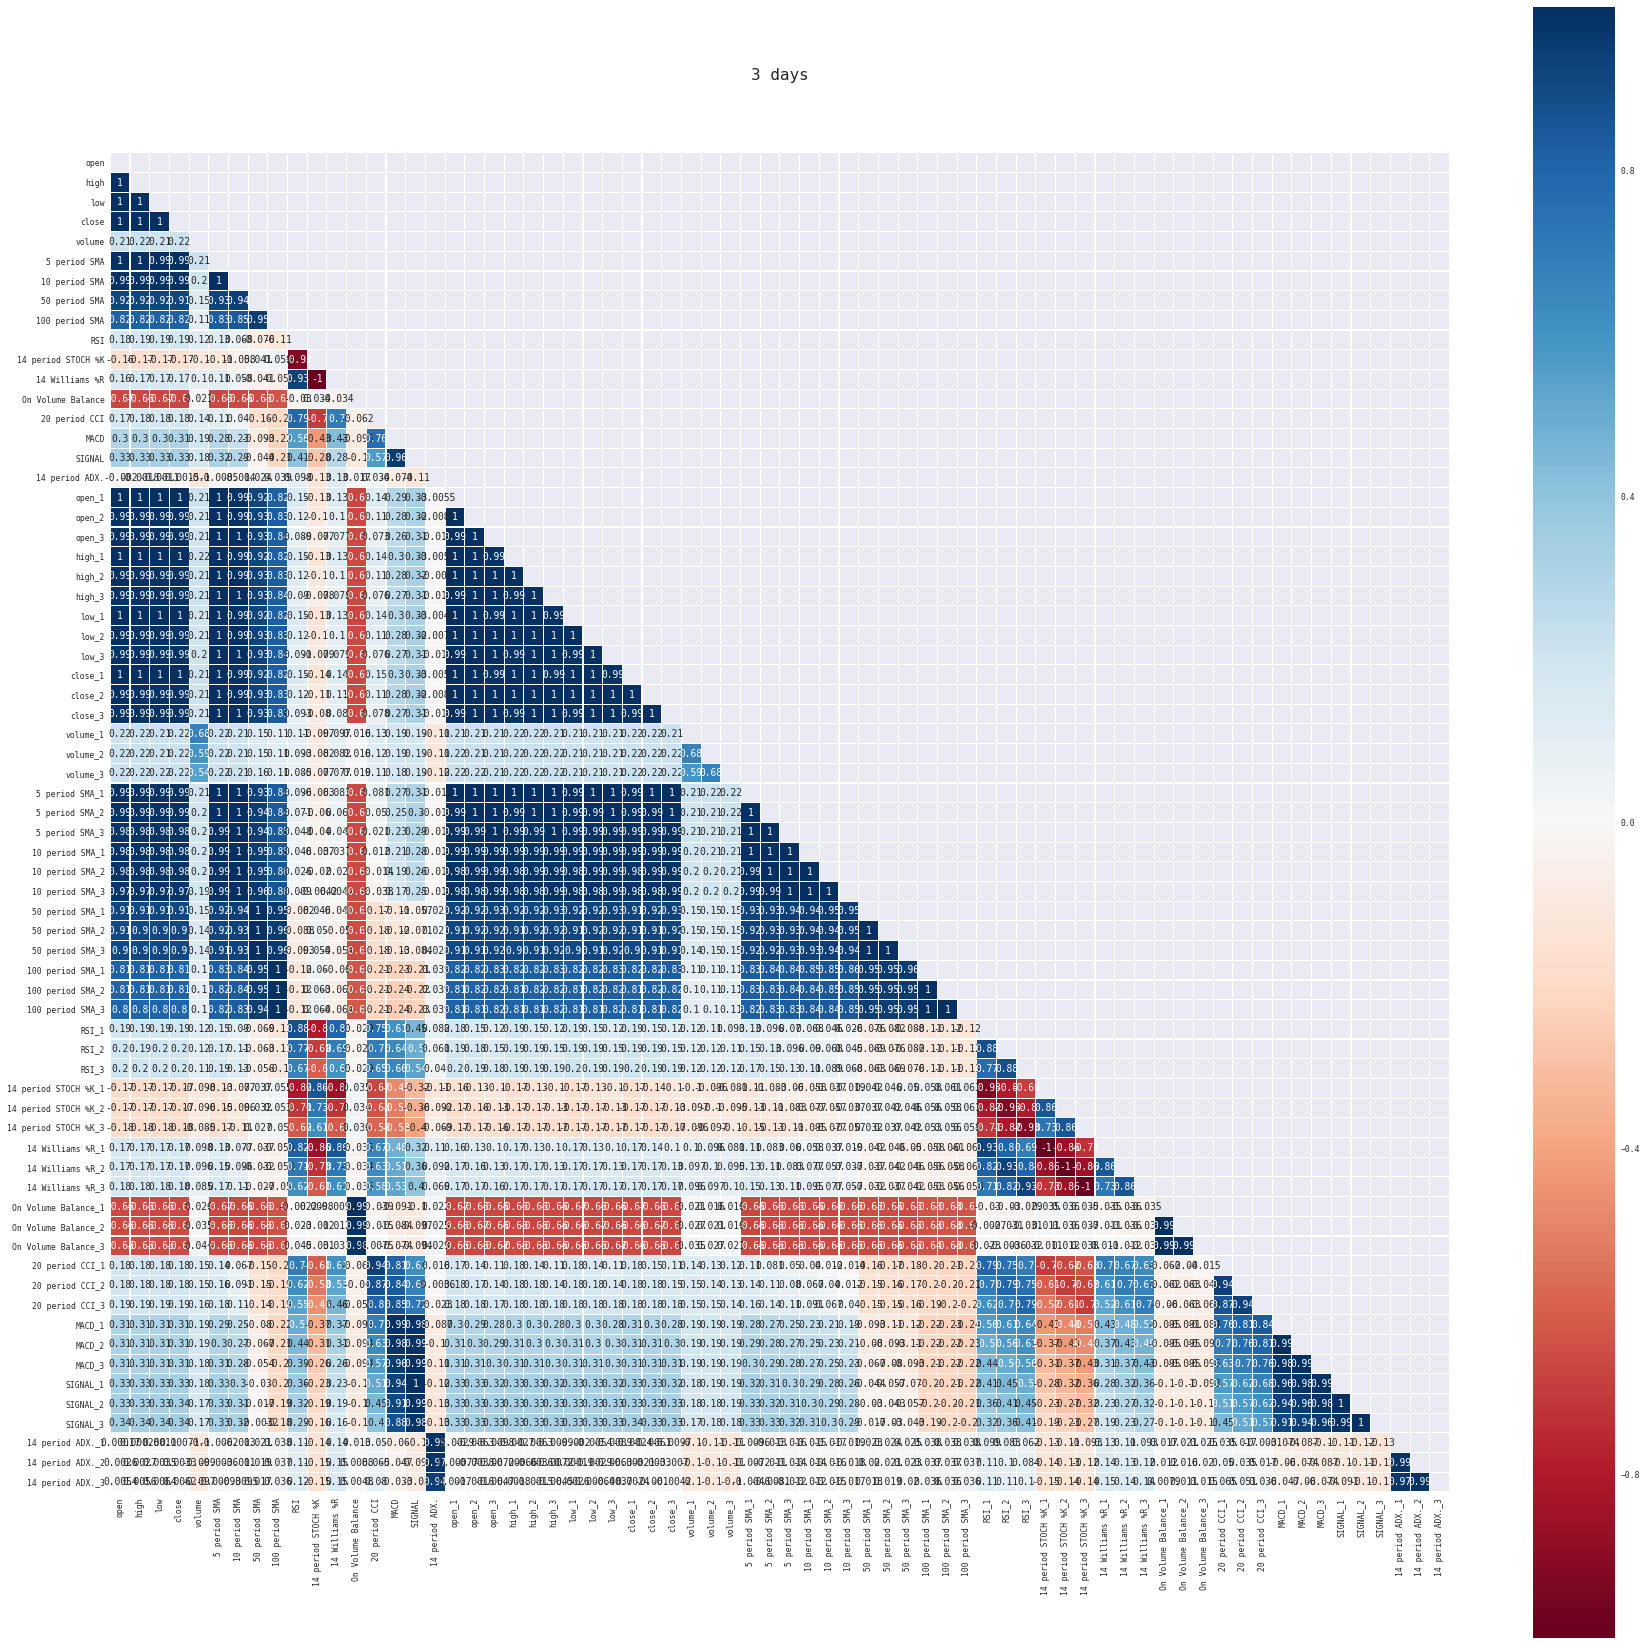

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# plot correlation
colormap = plt.cm.RdBu
plt.figure(figsize=(30,30))
plt.title(u'3 days', y=1.05, size=16)

mask = np.zeros_like(df_w.corr())
mask[np.triu_indices_from(mask)] = True

svm = sns.heatmap(df_w.corr(), mask=mask, linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

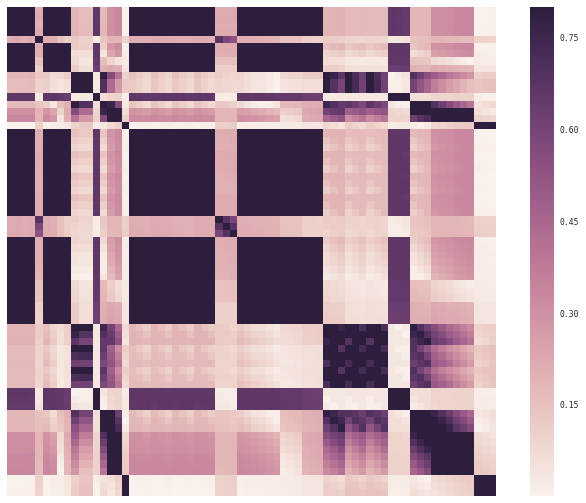

In [15]:
corrmat = df_w.corr(method='pearson', min_periods=1000)

# plot absolute values
corrmat = np.abs(corrmat)
sns.set(context="paper", font="monospace")
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, xticklabels = False, yticklabels = False)

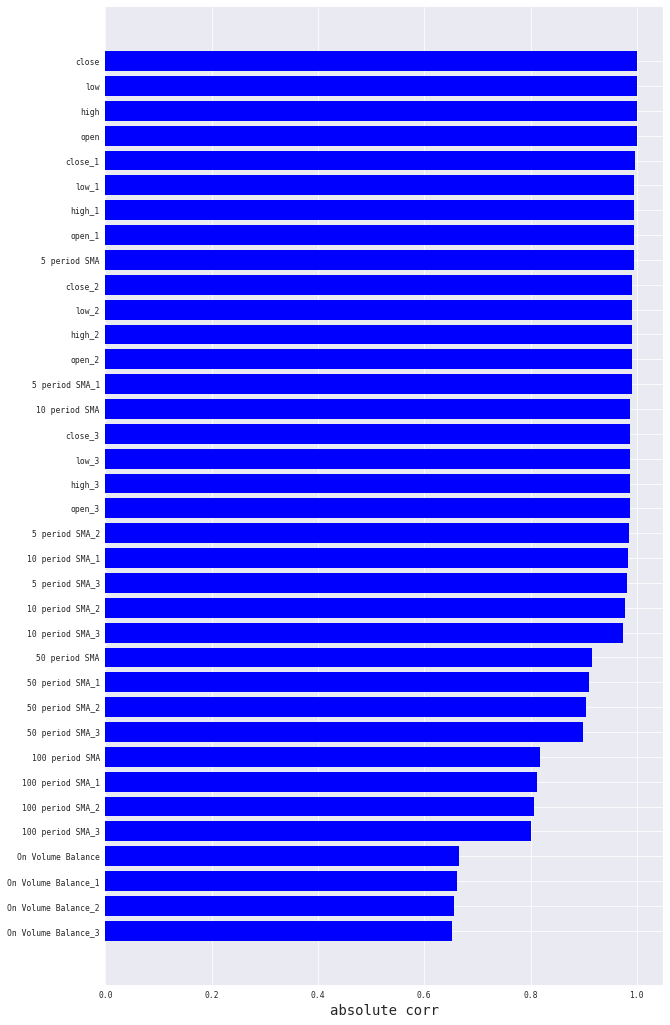

In [16]:
# correlation with close price

remain_num = 80
corr_target = corrmat['close'].reset_index()[:-2]
corr_target.columns = ['feature','abs_corr']
corr_target = corr_target.sort_values(by = 'abs_corr', ascending = True)[:remain_num].loc[corr_target['abs_corr'] >0.6]
ind = np.arange(corr_target.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(10,18))
rects = ax.barh(ind, corr_target.abs_corr.values, color='b')
ax.set_yticks(ind)
ax.set_yticklabels(corr_target.feature.values, rotation='horizontal')
ax.set_xlabel('absolute corr', fontsize = 14)
# ax.set_title("Correlations between features and stock trend ", fontsize = 18)
plt.show()